In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import datasets

% matplotlib inline

## Implement Regression class - wrapper for 4 regression model

In [9]:
class Regression:
    def __init__(self, model='linear', alpha=0.5, beta=0.5):
        """
        Regression model class. Default is linear regression

        :param model: 'linear' or 'ridge' or  'lasso' or 'elastic-net'
        :param alpha: decay value of 'ridge' or  'lasso' or 'elastic-net' regression
        :param beta: decay value of 'elastic-net' regression
        """
        assert model in ['linear', 'ridge', 'lasso', 'elastic-net'], "Not supported model"

        self.model = model
        self.alpha = alpha
        self.beta = beta
        self.w = np.array([])

    @staticmethod
    def _add_bias(x_):
        ones = np.ones((x_.shape[0], 1))
        return np.concatenate((x_, ones), axis=1)

    def predict(self, x_):
        if x_.shape[1] != self.w.shape[0]:
            x_ = self._add_bias(x_)
        return x_ @ self.w

    def _calc_loss(self, x_, y_):
        """
        Linear regression: norm_2(x @ w - y)
        Ridge regression: norm_2(x @ w - y) + alpha * norm_2(w)
        Lasso regression: norm_2(x @ w - y) + alpha * norm_1(w)
        ElasticNet regression: norm_2(x @ w - y) + alpha * norm_2(w) + beta * norm_1(w)
        """
        n = x_.shape[0]
        y_hat = self.predict(x_)
        common_loss = np.linalg.norm(y_hat - y_) / (2 * n)
        penalty = 0
        if self.model == 'ridge':
            penalty = np.linalg.norm(self.w) * self.alpha
        elif self.model == 'lasso':
            penalty = np.sum(self.w) * self.alpha
        elif self.model == 'elastic-net':
            penalty = np.linalg.norm(self.w) * self.alpha + np.sum(self.w) * self.beta

        return common_loss + penalty

    def _gradient(self, x_, y_):
        """
        Linear regression: x.T @ (x @ w - y)
        Ridge regression:  x.T @ (x @ w - y) + 2 * alpha * w
        Lasso regression:  x.T @ (x @ w - y) + alpha
        ElasticNet regression: x.T @ (x @ w - y) + 2 * alpha * w + beta
        """

        n = x_.shape[0]
        y_hat = self.predict(x_)
        common_gradient = (x_.T @ (y_hat - y_)) / n
        add_gradient = 0
        if self.model == 'ridge':
            add_gradient = 2 * self.alpha * self.w
        elif self.model == 'lasso':
            add_gradient = self.alpha
        elif self.model == 'elastic-net':
            add_gradient = 2 * self.alpha * self.w + self.beta

        return common_gradient + add_gradient

    def fit(self, train_data, n_epochs=1000, lr=0.01):
        x_train, y_train = train_data

        # add bias to input
        x_train = self._add_bias(x_train)

        # init weight
        self.w = np.random.rand(x_train.shape[1], 1)

        # train
        loss_hist = []
        for it in range(n_epochs):
            # calc loss
            train_loss = self._calc_loss(x_train, y_train)
            loss_hist.append(train_loss)

            # update weight
            self.w -= lr * self._gradient(x_train, y_train)

        return loss_hist

### Load sample data from sklearn dataset

In [10]:
def load_data(test_size=0.2):
    diabetes_x, diabetes_y = datasets.load_diabetes(return_X_y=True)

    scaler = StandardScaler()
    diabetes_x = scaler.fit_transform(diabetes_x, diabetes_y)

    diabetes_x = diabetes_x[:, 2].reshape(-1, 1)
    diabetes_y = diabetes_y.reshape(-1, 1)

    return train_test_split(diabetes_x, diabetes_y, test_size=test_size)

In [11]:
x_train, x_test, y_train, y_test = load_data()

### Train model

In [18]:
model = Regression(model='linear')
lr = 0.01
n_epochs = 500
loss_hist = model.fit((x_train, y_train), n_epochs=n_epochs, lr=lr)

### Visualize result

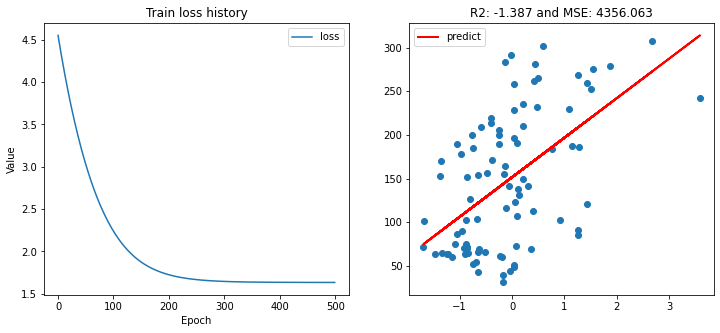

In [22]:
y_predict = model.predict(x_test)
r2 = r2_score(y_predict, y_test)
mse = mean_squared_error(y_predict, y_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(range(len(loss_hist)), loss_hist, label='loss')
ax1.set_title('Train loss history')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
ax1.legend()

ax2.scatter(x_test, y_test)
ax2.plot(x_test, y_predict, color='red', linewidth=2, label='predict')
ax2.set_title(f"R2: {r2:.3f} and MSE: {mse:.3f}")
ax2.legend()

plt.show()